# Integrantes
- Andrés Alexis Galvis Herrera
- Maria Camila Zapata Arrubla
- Juan José Zapata Cadavid

# Clasificación de semillas de trigo

## Comprendiendo la información del dataset

En el presente dataset se distingue tres diferentes tipos de trigo: Kama, Rosa and Canadian. Cada variedad incluye 70 granos, seleccionados aleatoriamente para el experimento. La estructura interna de los granos de trigo fue visualizada con una técnica de rayos X suaves, la cual es no destructiva y significativamente más económica que otras técnicas de imagen más sofisticadas, como la microscopía de barrido o la tecnología láser.

## Cargar librerías

In [ ]:
# Cargar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
# librerías Árboles de Decisión
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.feature_selection import SelectKBest
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

# librerías Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

## Cargar dataset

In [ ]:
# Cargar el archivo .xlsx en un DataFrame
data = pd.read_csv('wheat_seeds.csv',sep=';').drop('ID',axis=1)

# Aleatorizar los datos
data = data.sample(frac=1,random_state=42).reset_index(drop=True)
data.head()

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
0,13.16,13.82,8.662,5.454,2.975,8.551,5.056,1
1,11.27,12.97,8.419,5.088,2.763,4.309,5.000,3
2,19.51,16.71,878.000,6.366,3.801,2.962,6.185,2
3,12.76,13.38,8.964,5.073,3.155,2.828,4.830,3
4,11.42,12.86,8.683,5.008,2.850,2.700,4.607,1


# Primer punto

## Pre-Procesamiento

In [ ]:
data.shape

(210, 8)

In [ ]:
data.dtypes

,0
area,float64
perimeter,float64
compactness,float64
lengthOfKernel,float64
widthOfKernel,float64
asymmetryCoefficient,float64
lengthOfKernelGroove,float64
seedType,int64


Vemos que tratamos con datos de tipo flotante y entero.
Sabemos que seedType al definir diferentes tipos de semillas es una variable categórica.

In [ ]:
# Convertir la columna 'seedType' a tipo categórico
data['seedType'] = data['seedType'].astype('category')

In [ ]:
data.isnull().sum()

,0
area,0
perimeter,0
compactness,0
lengthOfKernel,0
widthOfKernel,0
asymmetryCoefficient,0
lengthOfKernelGroove,0
seedType,0


In [ ]:
#Ver los valores únicos que sean diferente a float o category, para ver si hay valores nulos
for column in data.columns:
    if data[column].dtype not in [float,'category']:
        unique_values = data[column].unique()
        print(f"Valores únicos de la variable {column}: {unique_values}")

Con lo anterior se observa que no tenemos valores nulos, no hay valores que sean diferentes a valores continuos.

## Identificación de variables

In [ ]:
data.columns

Index(['area', 'perimeter', 'compactness', 'lengthOfKernel', 'widthOfKernel',
       'asymmetryCoefficient', 'lengthOfKernelGroove', 'seedType'],
      dtype='object')

In [ ]:
data.describe()

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,107.619557,5.628533,3.258605,8.065338,5.408071
std,2.909699,1.305959,276.318537,0.443063,0.377714,62.070564,0.491480
min,10.590000,12.410000,0.880000,4.899000,2.630000,1.018000,4.519000
25%,12.270000,13.450000,8.576000,5.262250,2.944000,2.690750,5.045000
50%,14.355000,14.320000,8.763000,5.523500,3.237000,3.634500,5.223000
75%,17.305000,15.715000,8.975000,5.979750,3.561750,4.856000,5.877000
max,21.180000,17.250000,905.000000,6.675000,4.033000,903.000000,6.550000


- Entre las variables que se encuentran en el dataset se observa que la variable que nos servirá a predecir y será de gran utilidad es "seedType", esta nos ayudará a determinar el tipo de semilla de trigo.

- Las demás variables serán consideradas como features para entrenar el modelo.

- De los estadíticos descriptivos tenemos que se observa en la variable compactness una desviación estándar de 107.62, lo cual indica una mayor variabilidad en los datos, mientras que en la variable como lengthOfKernel tiene una desviación estándar de 0.44, por lo que la variabilidad es menor.

- Al ver cómo se comportan los datos, se concluye que estos no requieren de un pre-procesamiento, los datos se encuentran disponibles para usarlos.

## Distribución variable objetivo

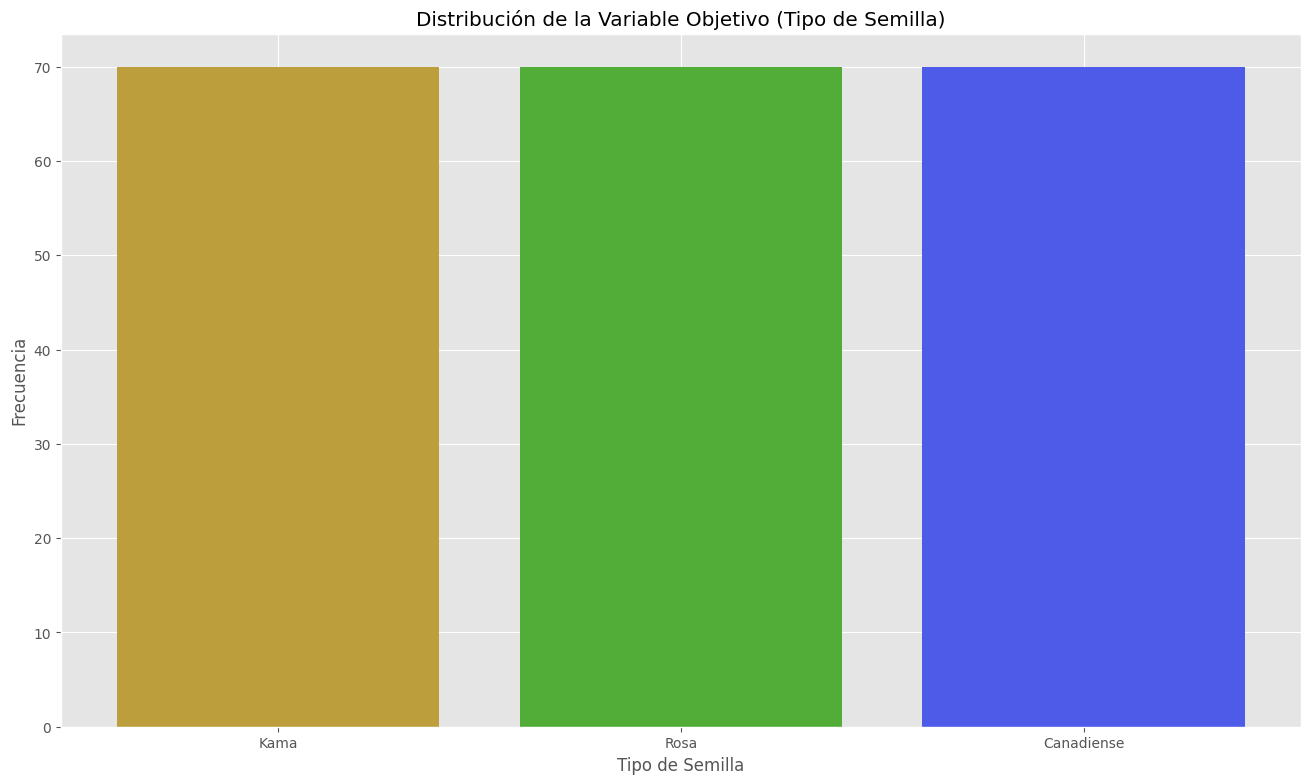

In [ ]:
target_distribution = data['seedType'].value_counts()

plt.bar(target_distribution.index, target_distribution.values, color=['#BD9E3C', '#51AD38', '#4D5BE8'])
plt.xlabel('Tipo de Semilla')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Variable Objetivo (Tipo de Semilla)')
plt.xticks(target_distribution.index, ['Kama', 'Rosa', 'Canadiense'])
plt.show()

Se observa una que las diferentes clase o tipos de semillas están distribuidas equitativamente.

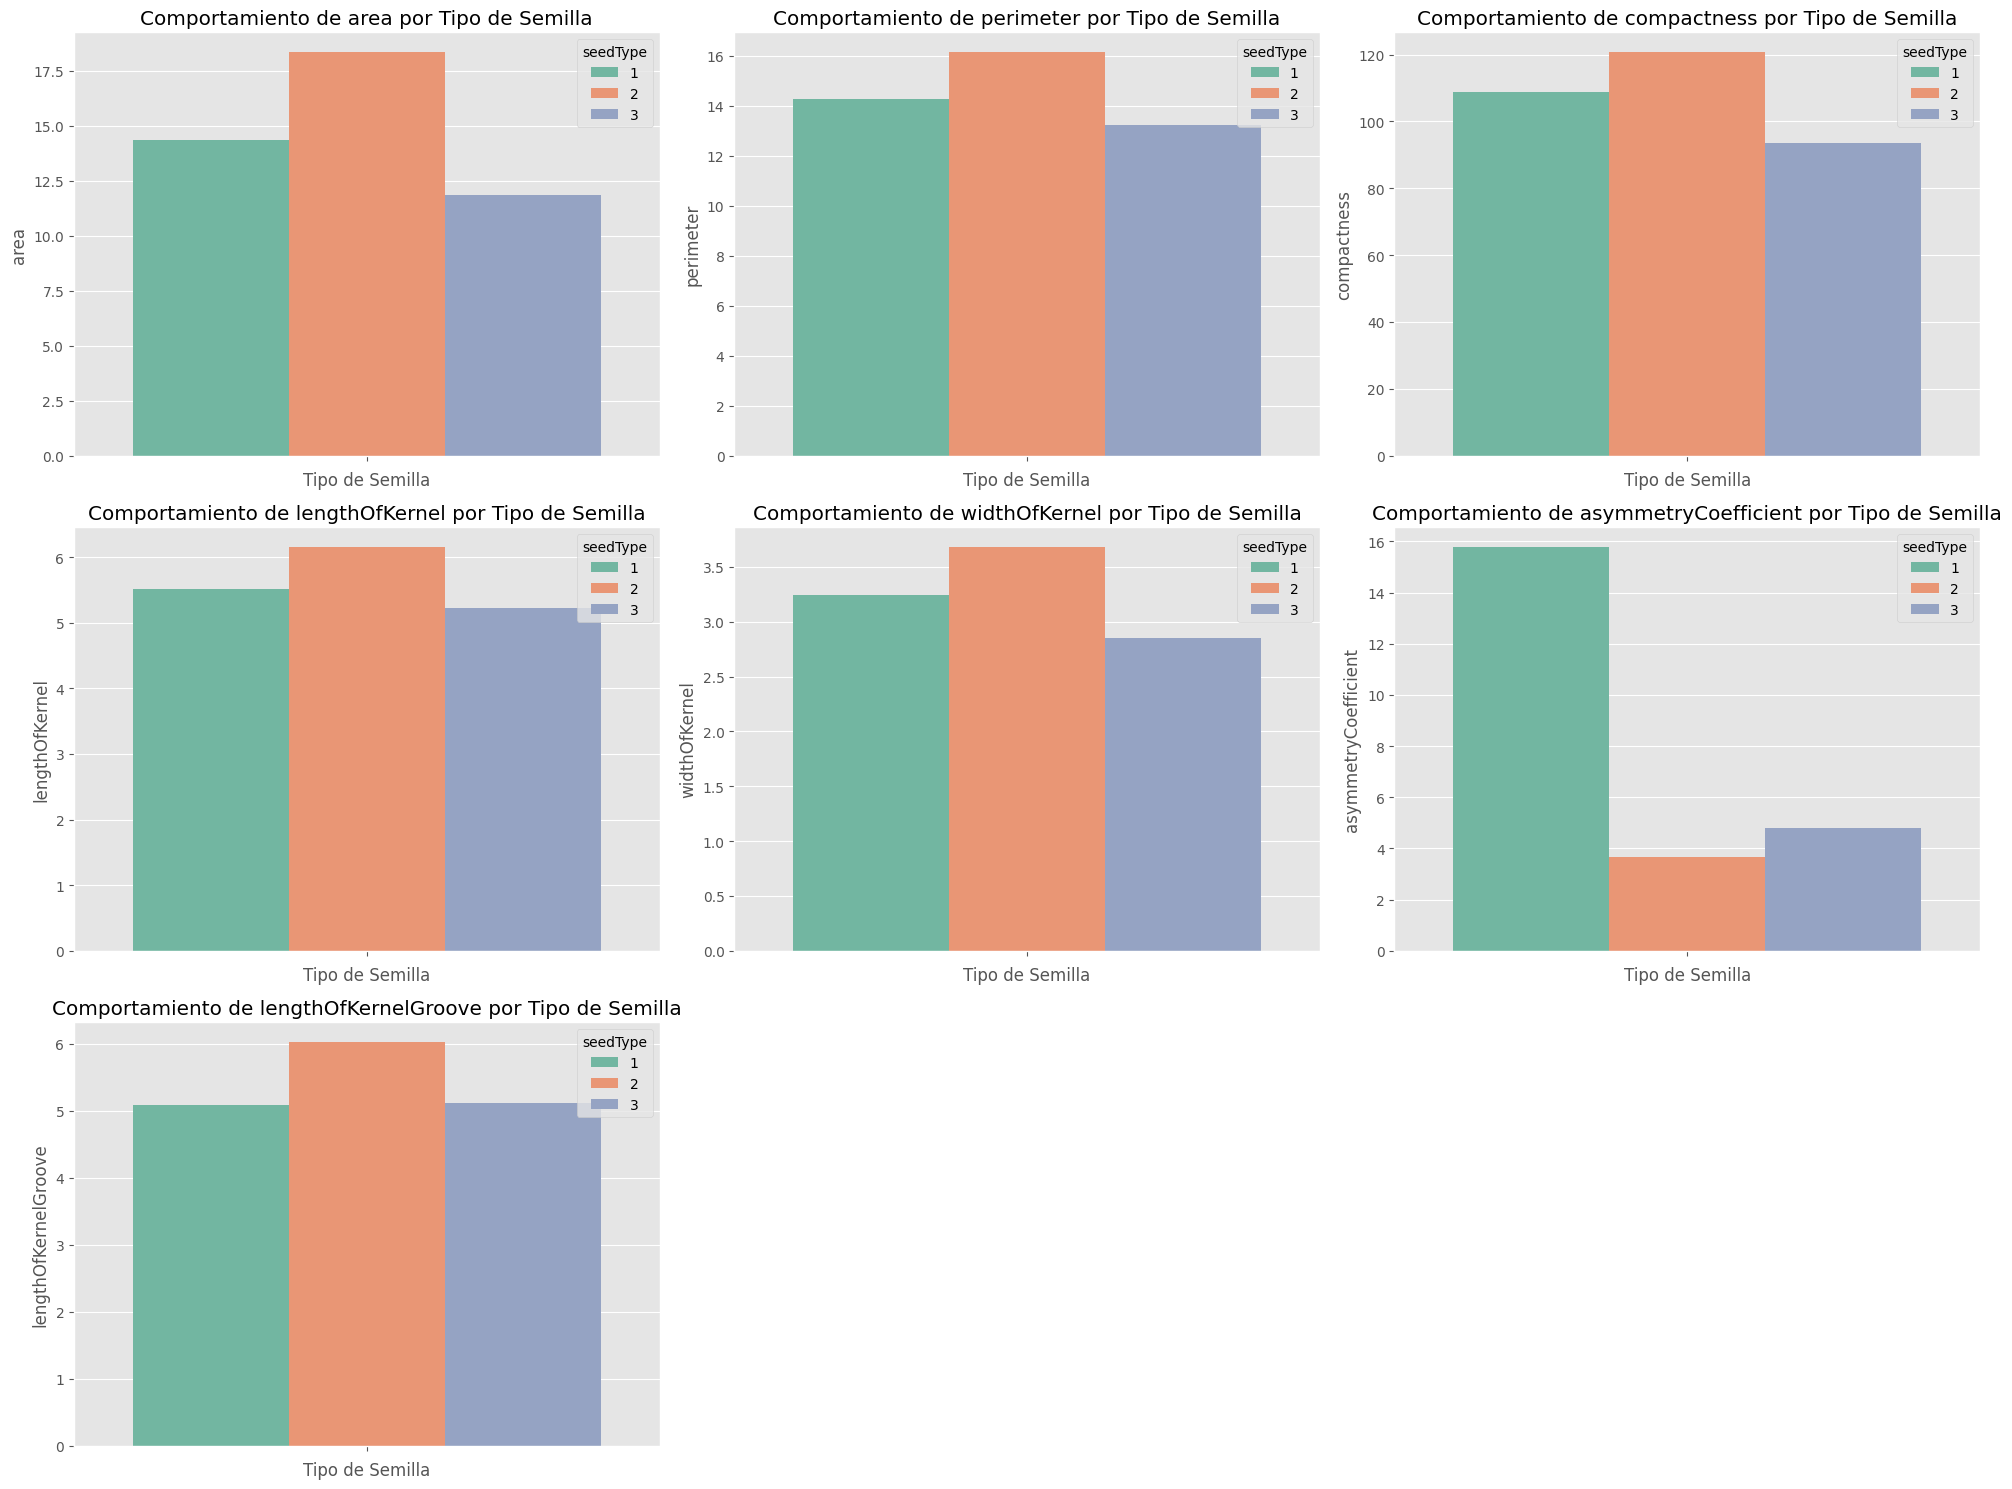

In [ ]:
# Crea subplots por cada característica
plt.figure(figsize=(20, 15))

for i, feature in enumerate(data.columns[:-1]):  # Excluye 'seedType'
    plt.subplot(3, 3, i + 1)
    sns.barplot(hue='seedType', y=feature, data=data, errorbar=None, palette='Set2')
    plt.title(f'Comportamiento de {feature} por Tipo de Semilla')
    plt.xlabel('Tipo de Semilla')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()


De las distribuciones anteriores se concluye que:
- El tipo de semilla Rosa es la que más sobresale por estar en un área mayor que las demás, el perimetro también es mayor, la compacidad (compactness) es superior a la de las demás. Viendo el aspecto del grano tanto su longitud como ancho es mayor a las demás.

## Comportamiento de las variables

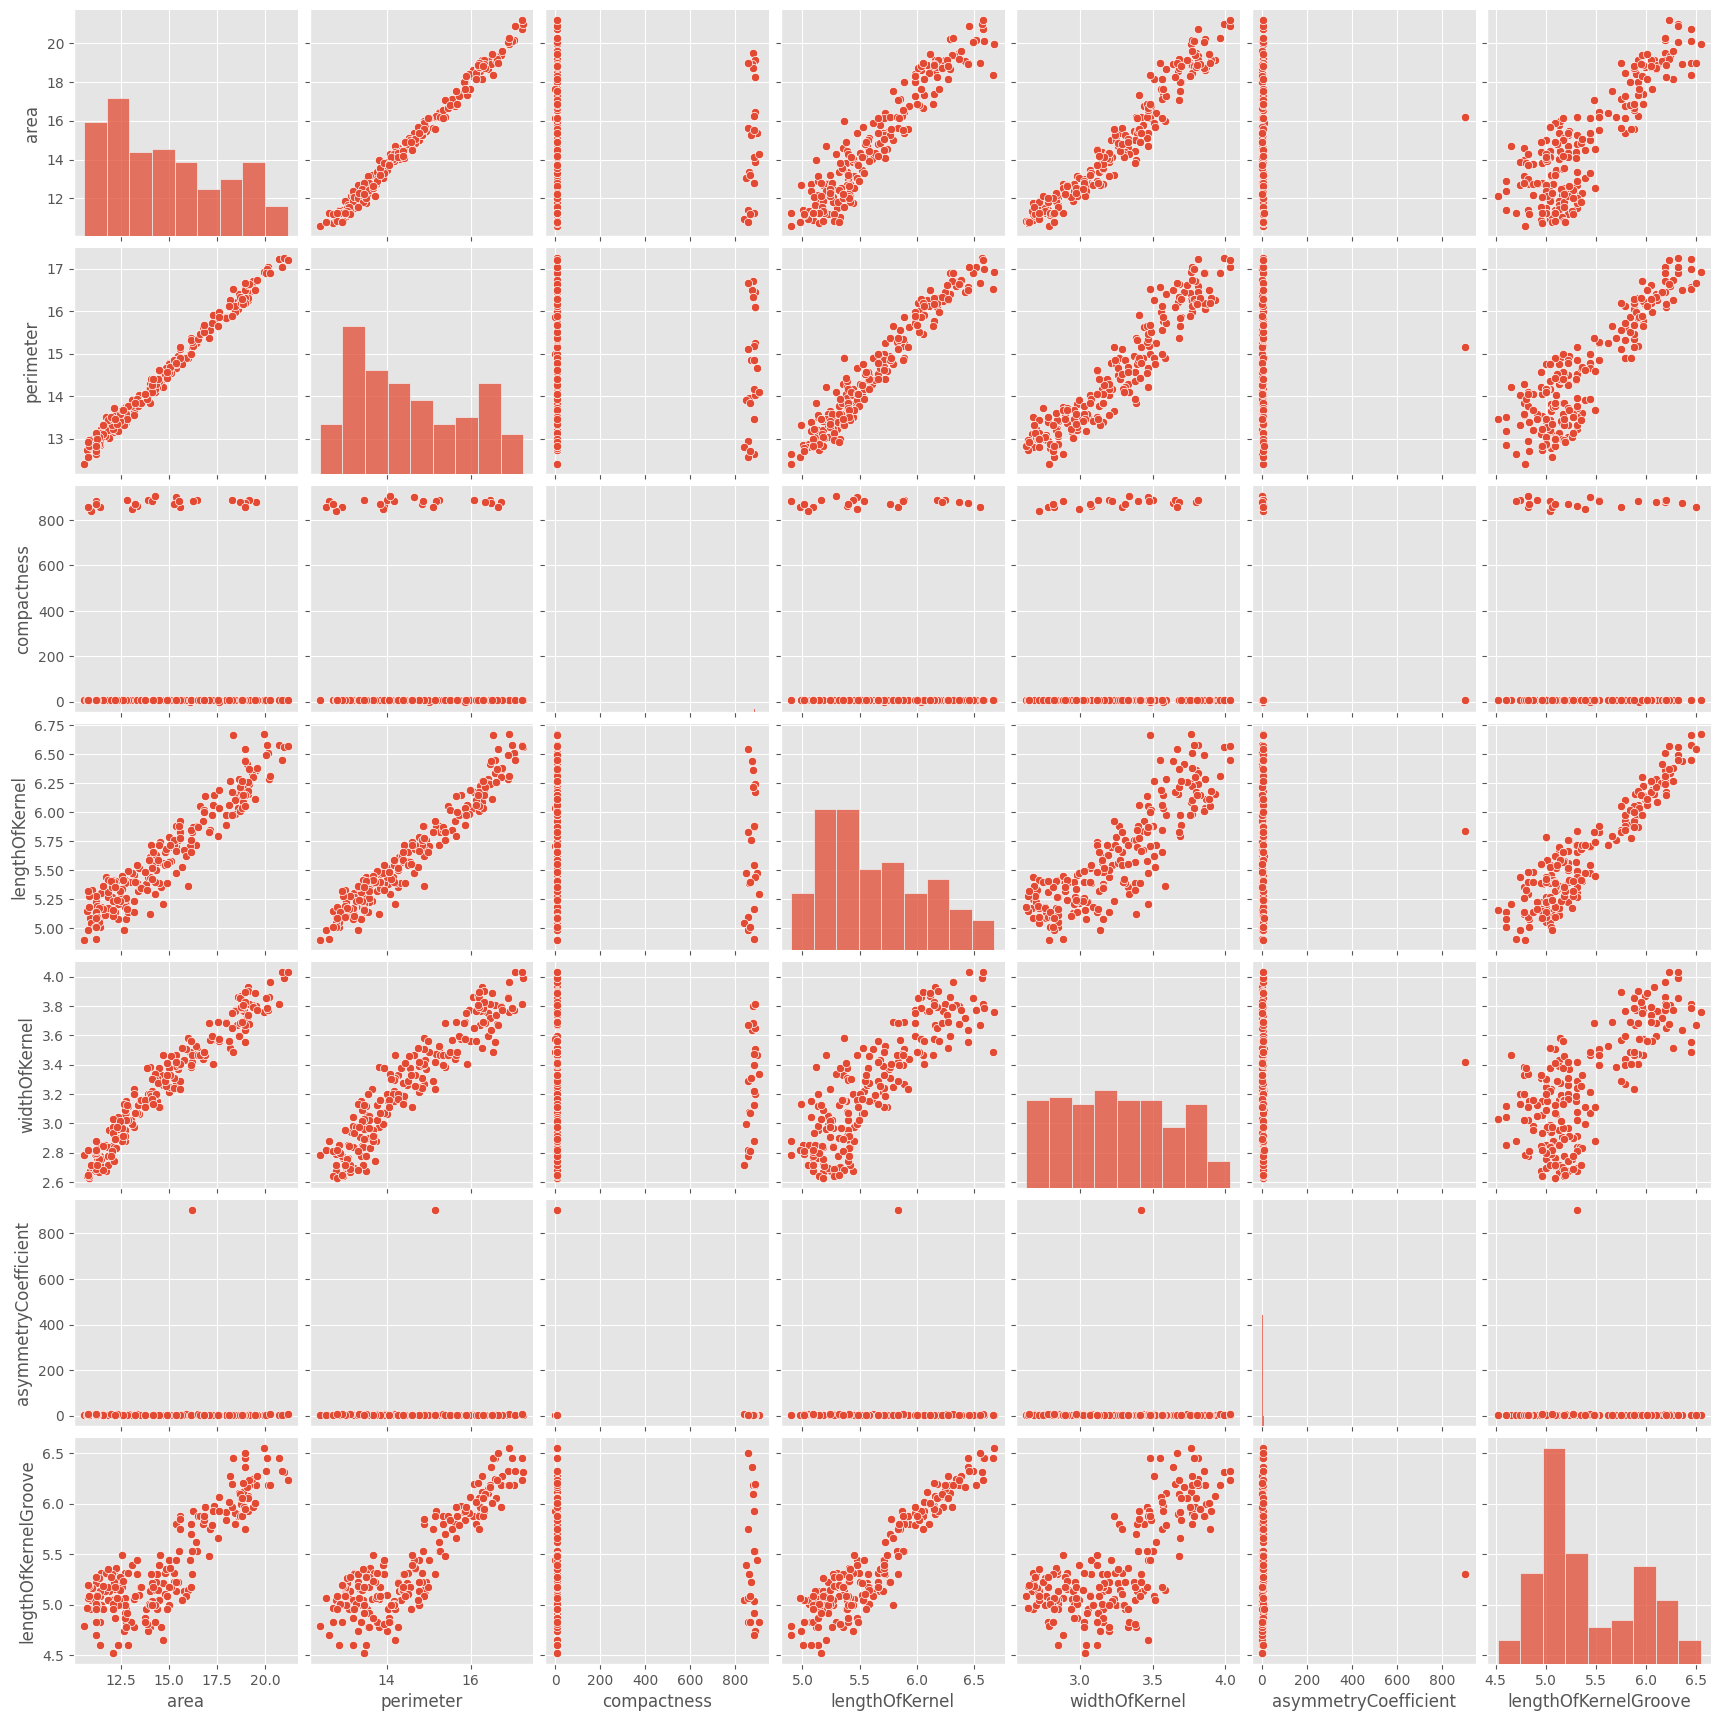

In [ ]:
sns.pairplot(data)
plt.show()

# Segundo punto

In [ ]:
seed = data.copy()

In [ ]:
#Mezclar datos
seed = seed.sample(frac=1,random_state=42).reset_index(drop=True)

#Features
X = seed.drop(['seedType'], axis=1)
#Variable objetivo
y = seed['seedType']

In [ ]:
X = np.array(X)
y = np.array(y)

## Métrica Entropía

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1) # Numero de "folds: Subconjuntos" en que se dividen los datos de entrenamiento,
                                                                # Lo prueba con n-1 holds restantnes,
accuracies = list()
max_attributes = len(list(seed))
depth_range = range(1, max_attributes + 1)

# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight='balanced') # Por defecto todas las clases tienen peso 1
                                                                        # tambien se puede usar 'balanced'
    for train_index, valid_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[valid_index]    #Validación cruzada.
        y_train, y_test = y[train_index], y[valid_index]

        model = tree_model.fit(X_train, y_train)
        valid_acc = model.score(X_test, y_test) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    # almacenamos acc promedio para cada profundidad
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)

# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.652381
         2          0.919048
         3          0.885714
         4          0.876190
         5          0.880952
         6          0.885714
         7          0.895238
         8          0.885714


## Métrica Gini

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1) # Numero de "folds: Subconjuntos" en que se dividen los datos de entrenamiento,
                                                                # Lo prueba con n-1 holds restantnes,
accuracies = list()
max_attributes = len(list(seed))
depth_range = range(1, max_attributes + 1)

# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='gini',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight='balanced') # Por defecto todas las clases tienen peso 1
                                                                        # tambien se puede usar 'balanced'
    for train_index, valid_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[valid_index]    #Validación cruzada.
        y_train, y_test = y[train_index], y[valid_index]

        model = tree_model.fit(X_train, y_train)
        valid_acc = model.score(X_test, y_test) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    # almacenamos acc promedio para cada profundidad
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)

# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.652381
         2          0.904762
         3          0.914286
         4          0.914286
         5          0.914286
         6          0.914286
         7          0.914286
         8          0.914286


## ¿Cuál métrica es mejor?

### Análisis de resultados
#### Entropía

- La precisión promedio comienza en 0.652 cuando la profundidad máxima del árbol es 1.
- La precisión aumenta significativamente a 0.919 cuando la profundidad es 2, pero luego comienza a fluctuar ligeramente.
- La mejor precisión promedio (0.895) se obtiene con una profundidad de 7, pero las diferencias son relativamente pequeñas en comparación con las profundidades mayores.
- Al mostrar más variabilidad en sus datos, podría ser un indicio de un modelo ajustado a los datos de entrenamiento y esto podría ser un mayor riesgo al sobreajuste.

#### Índice Gini:

- Al igual que con entropía, la precisión comienza en 0.652 cuando la profundidad máxima es 1.
- A partir de una profundidad de 3, la precisión se estabiliza en 0.914 y no cambia al incrementar la profundidad hasta 8.
- Muestra una estabilidad en la precisión a partir de una profundidad de 3, lo que indica que aumentar la profundidad más allá de este punto no mejora el rendimiento. Esta estabilidad sugiere que el modelo con índice Gini es menos susceptible a sobreajuste.

### Conclusión

El modelo basado en la métrica de Gini es preferible para este caso debido a su mayor estabilidad y consistencia en la precisión a medida que aumenta la profundidad del árbol.

# Tercer punto

### Justificación de la División
#### Balance entre Entrenamiento y Evaluación:

- Usar un 70% para entrenamiento asegura que el modelo tiene suficientes datos para aprender patrones complejos, mientras que un 30% para prueba es suficiente para obtener una estimación confiable de cómo se comportará el modelo en datos no vistos.

#### Generalización:

- Dividir los datos de esta manera ayuda a garantizar que el modelo generalice bien a datos nuevos. Si se usara una proporción muy baja de datos para la prueba, podríamos sobreestimar el rendimiento del modelo porque estaría siendo evaluado en un conjunto pequeño y posiblemente no representativo.

#### Evitar Overfitting:

- Una proporción adecuada de datos de prueba ayuda a detectar si el modelo está sobreajustando (overfitting) los datos de entrenamiento. Si el modelo tiene un rendimiento muy alto en el entrenamiento pero bajo en la prueba, esto indicaría sobreajuste.

# Cuarto punto

## ¿Qué variables usar en la clasificación?

Como tenemos una variable categórica(seedType) la correlación de Pearson no es la más viable ya que esta se utiliza para medir la relación entre dos variables continuas.
Con lo anterior se hará la matriz de correlación de Cramer's V ya que esta es la medida más apropiada para evaluar la relación entre una variable categórica y otra, ya sea categórica o numérica.

### Matriz de correlación Cramer's V

In [ ]:
from scipy.stats import chi2_contingency

def cramers_V(var1, var2):
  crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))
  stat = chi2_contingency(crosstab)[0]
  obs = np.sum(crosstab)
  mini = min(crosstab.shape) - 1
  return (stat/(obs*mini))

In [ ]:
rows= []

for var1 in seed:
  col = []
  for var2 in seed :
    cramers =cramers_V(seed[var1], seed[var2])
    col.append(round(cramers,2))
  rows.append(col)

cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = seed.columns, index =seed.columns)


df

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
area,1.00,0.91,0.92,0.92,0.92,0.99,0.92,0.97
perimeter,0.91,1.00,0.88,0.90,0.87,0.99,0.82,0.93
compactness,0.92,0.88,1.00,0.90,0.88,0.99,0.87,0.89
lengthOfKernel,0.92,0.90,0.90,1.00,0.90,0.99,0.91,0.96
widthOfKernel,0.92,0.87,0.88,0.90,1.00,0.99,0.88,0.95
asymmetryCoefficient,0.99,0.99,0.99,0.99,0.99,1.00,0.99,0.99
lengthOfKernelGroove,0.92,0.82,0.87,0.91,0.88,0.99,1.00,0.80
seedType,0.97,0.93,0.89,0.96,0.95,0.99,0.80,1.00


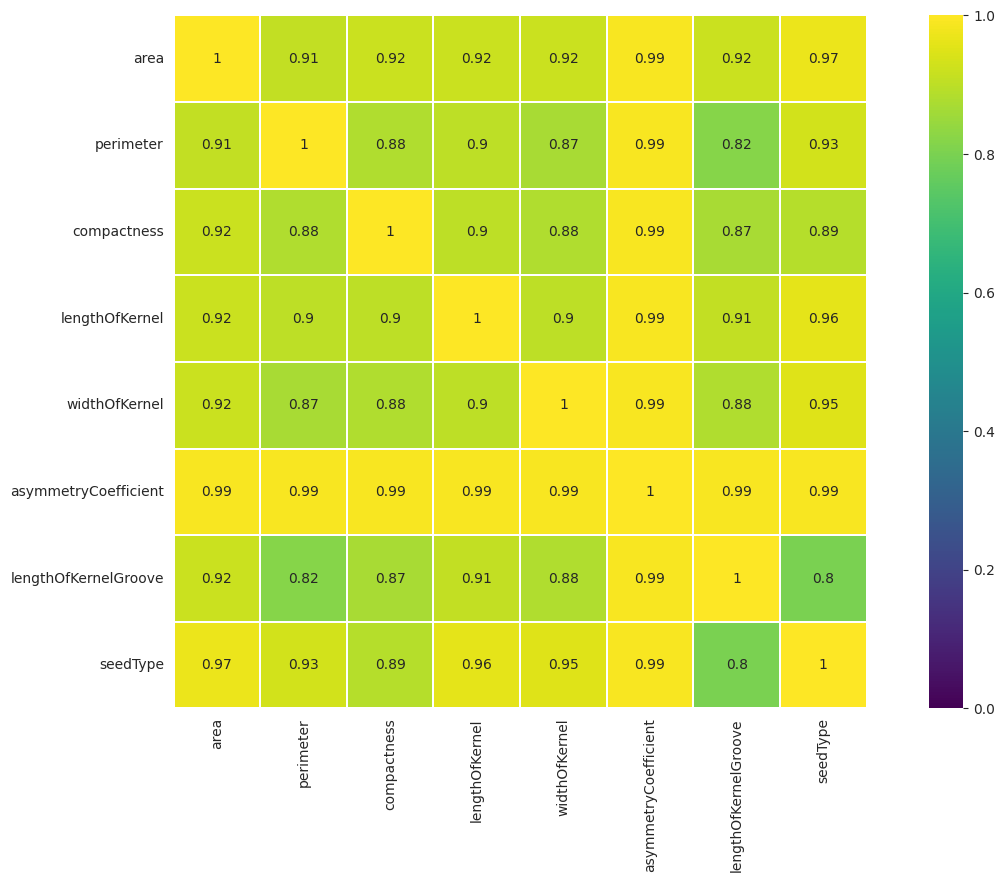

In [ ]:
with sns.axes_style("white"):
  ax = sns.heatmap(df,
                  vmin=0.,
                  vmax=1,
                  cmap='viridis',
                  annot=True,
                  linewidths=0.1,
                  square=True)

plt.show()

### SelectKBest: ¿Qué variables tienen mayor impacto qué otras a la variable objetivo?

In [ ]:
#Mezclar datos, aunque ya se mezclaron mas arriba
seed=seed.sample(frac=1,random_state=42).reset_index(drop=True)

#Todos los datos excepto la caracteristica objetivo.
X = seed.drop(['seedType'], axis=1)

#CARACTERÍSTICA OBJETIVO
y = seed['seedType']

best=SelectKBest(k=5)

X_new = best.fit_transform(X, y)
X_new.shape
selected = best.get_support(indices=True)
print(X.columns[selected])

Index(['area', 'perimeter', 'lengthOfKernel', 'widthOfKernel',
       'lengthOfKernelGroove'],
      dtype='object')


### Conclusiones
- Con lo anterior se evidencia que para la matriz de correlación de Cramer's V, la variable que mayor correlación tiene con respecto a seedType es asymmetry coefficient con una correlación de 0.99 y la que menor correlación tiene es length of kernel groove con una correlación de 0.8, en general se observó que las variables tenían gran correlación con seedType.
- Al aplicar SelectKbest, se observa que no se escoge asymmetry coefficient y se considera lengthOfKernelGroove.

In [ ]:
# Definir X con las características seleccionadas por SelectKBest
X = data[['area', 'perimeter', 'lengthOfKernel', 'widthOfKernel','lengthOfKernelGroove']]

# Definir y como la variable objetivo
y = data['seedType']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar el modelo de Árbol de Decisión
tree = DecisionTreeClassifier(criterion='gini', random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

# Quinto punto

Se usará GridSearchCV para buscar el mejor modelo en base a una "grilla" de parámetros, como vimos anteriormente el mejor criterio para este dataset es gini, por lo que se usará para buscar la mejor profundidad, con un K-Fold = 5 para el crossvalidation

In [ ]:
param_grid = {
    'max_depth': range(2, 11)
}

model = DecisionTreeClassifier(criterion = "gini")

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring="accuracy")

grid_search.fit(X_train, y_train)

print("Mejor parámetro encontrado:", grid_search.best_params_)
print("Mejor precisión:", grid_search.best_score_)

Mejor parámetro encontrado: {'max_depth': 8}
Mejor precisión: 0.9524137931034483


En este caso encontramos que la mejor profundidad es de 3, con un promedio de 0.9522, pero vamos a ver los scores de las demás profundidades

In [ ]:
results = grid_search.cv_results_

for mean_score, params in zip(results["mean_test_score"], results["params"]):
    print(f"Exactitud promedia: {mean_score:.5f} - Parámetros: {params}")

Exactitud promedia: 0.93885 - Parámetros: {'max_depth': 2}
Exactitud promedia: 0.95218 - Parámetros: {'max_depth': 3}
Exactitud promedia: 0.93862 - Parámetros: {'max_depth': 4}
Exactitud promedia: 0.93172 - Parámetros: {'max_depth': 5}
Exactitud promedia: 0.95218 - Parámetros: {'max_depth': 6}
Exactitud promedia: 0.93172 - Parámetros: {'max_depth': 7}
Exactitud promedia: 0.95241 - Parámetros: {'max_depth': 8}
Exactitud promedia: 0.94529 - Parámetros: {'max_depth': 9}
Exactitud promedia: 0.95241 - Parámetros: {'max_depth': 10}


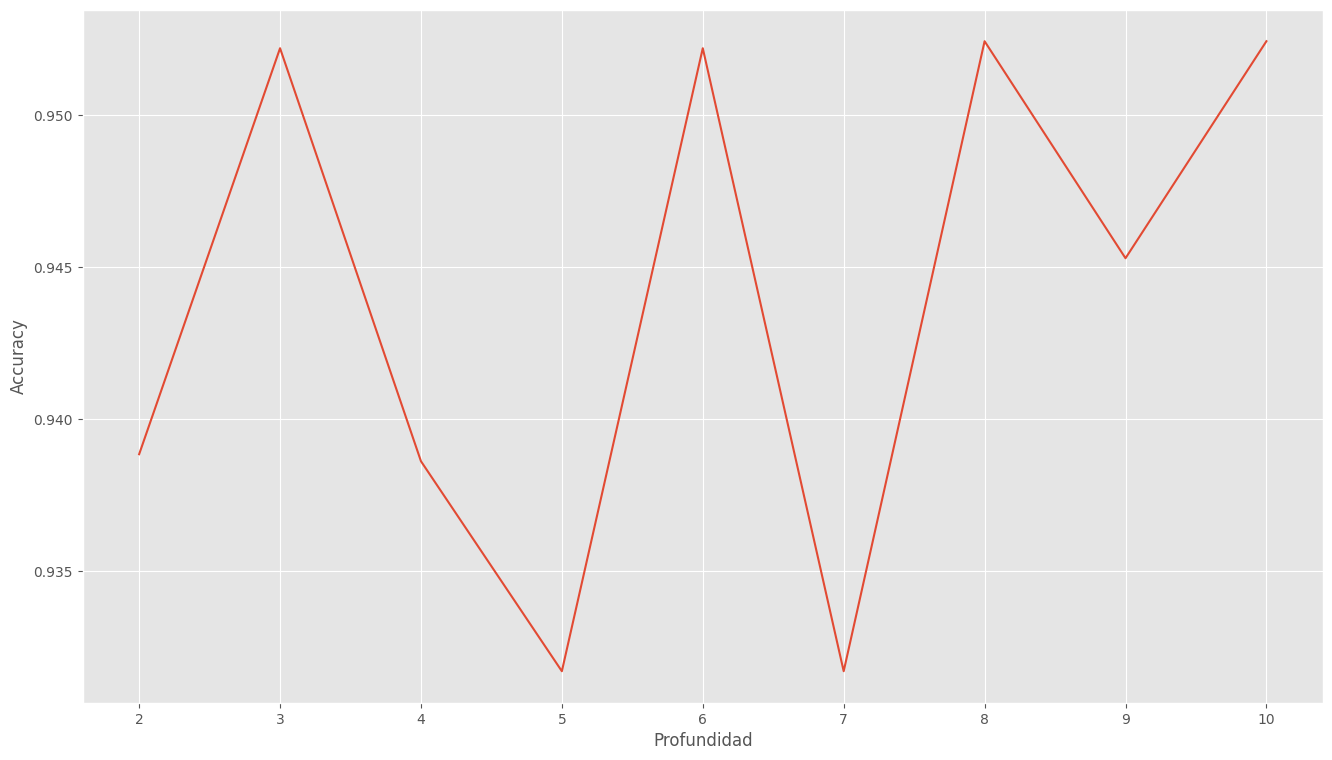

In [ ]:
plt.plot([x["max_depth"] for x in results["params"]], results["mean_test_score"])
plt.xlabel("Profundidad")
plt.ylabel("Accuracy")
plt.show()

Podemos observar que la profundidad 10 tiene un accuracy similar, pero escogemos el max_depth = 3 por ser el modelo más sencillo

# Sexto punto

Se usará la misma técnica para encontrar estos parámetros, colocando los parámetros ya encontrados anteriormente

In [ ]:
param_grid = {
    "min_samples_split": range(2, 5),
    "min_samples_leaf": range(1, 5)
}

model = DecisionTreeClassifier(max_depth = 3, criterion = "gini")

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', error_score="raise")

grid_search.fit(X_train, y_train)

print("Mejores parámetros encontrados:", grid_search.best_params_)
print("Mejor precisión de validación cruzada:", grid_search.best_score_)

Mejores parámetros encontrados: {'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor precisión de validación cruzada: 0.9521839080459771


En este caso encontramos un minimo de muestras de hojas de 1 y un minimo de muestras para la división de nodos de 2 para una precisión de 0.9522, igual al accuracy ya obtenido anteriormente debido a que estos son los valores por defectos.

In [ ]:
results = grid_search.cv_results_
# Iteramos los resultados del GridSearchCV para ver la métrica de cada selección de parámetros
for mean_score, params in zip(results["mean_test_score"], results["params"]):
    print(f"Exactitud promedia: {mean_score:.5f} - Parámetros: {params}")

Exactitud promedia: 0.95218 - Parámetros: {'min_samples_leaf': 1, 'min_samples_split': 2}
Exactitud promedia: 0.95218 - Parámetros: {'min_samples_leaf': 1, 'min_samples_split': 3}
Exactitud promedia: 0.95218 - Parámetros: {'min_samples_leaf': 1, 'min_samples_split': 4}
Exactitud promedia: 0.91172 - Parámetros: {'min_samples_leaf': 2, 'min_samples_split': 2}
Exactitud promedia: 0.93195 - Parámetros: {'min_samples_leaf': 2, 'min_samples_split': 3}
Exactitud promedia: 0.92529 - Parámetros: {'min_samples_leaf': 2, 'min_samples_split': 4}
Exactitud promedia: 0.93195 - Parámetros: {'min_samples_leaf': 3, 'min_samples_split': 2}
Exactitud promedia: 0.93195 - Parámetros: {'min_samples_leaf': 3, 'min_samples_split': 3}
Exactitud promedia: 0.93195 - Parámetros: {'min_samples_leaf': 3, 'min_samples_split': 4}
Exactitud promedia: 0.92506 - Parámetros: {'min_samples_leaf': 4, 'min_samples_split': 2}
Exactitud promedia: 0.92506 - Parámetros: {'min_samples_leaf': 4, 'min_samples_split': 3}
Exactitud 

En este caso no vimos necesario hacer un balance de los pesos de los datos dado que anteriormente vimos que las cantidades en las 3 clases era igual.

In [ ]:
data["seedType"].value_counts()

,count
seedType,
1,70
2,70
3,70


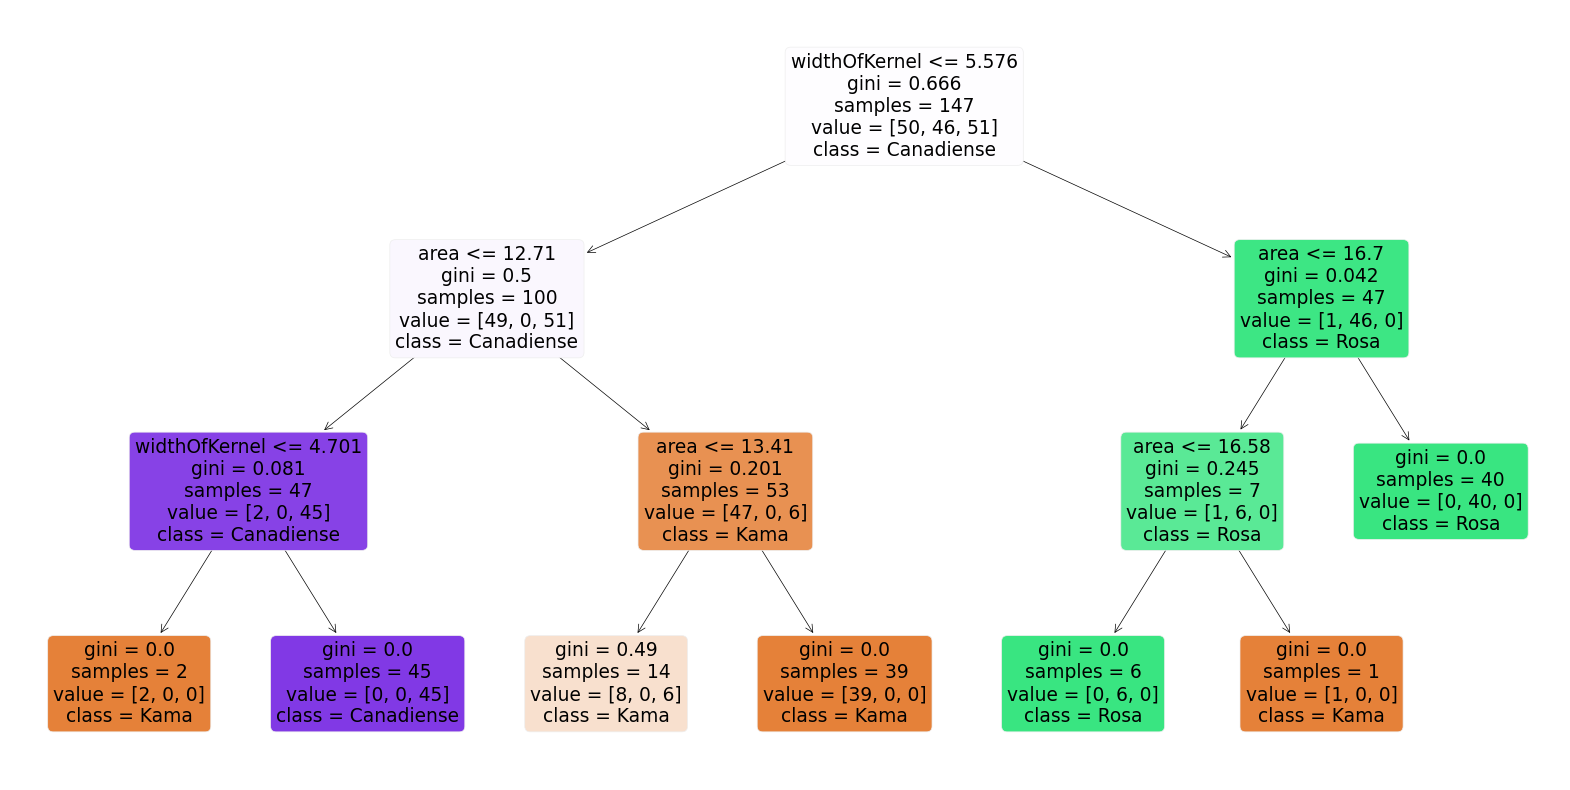

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(grid_search.best_estimator_, feature_names=data.columns, class_names=["Kama", "Rosa", "Canadiense"], filled=True, rounded=True)
plt.show()

Del gráfico del árbol de decisión vemos que el nodo raíz usa WidthOfKernel; las variables que se usan en los nodos hijos son area y widhtOfKernel.

# Séptimo punto

In [ ]:
final_model = DecisionTreeClassifier(
    criterion = "gini",
    max_depth = 3
)

final_model.fit(X_train, y_train)

y_test_pred = final_model.predict(X_test)
y_train_pred = final_model.predict(X_train)

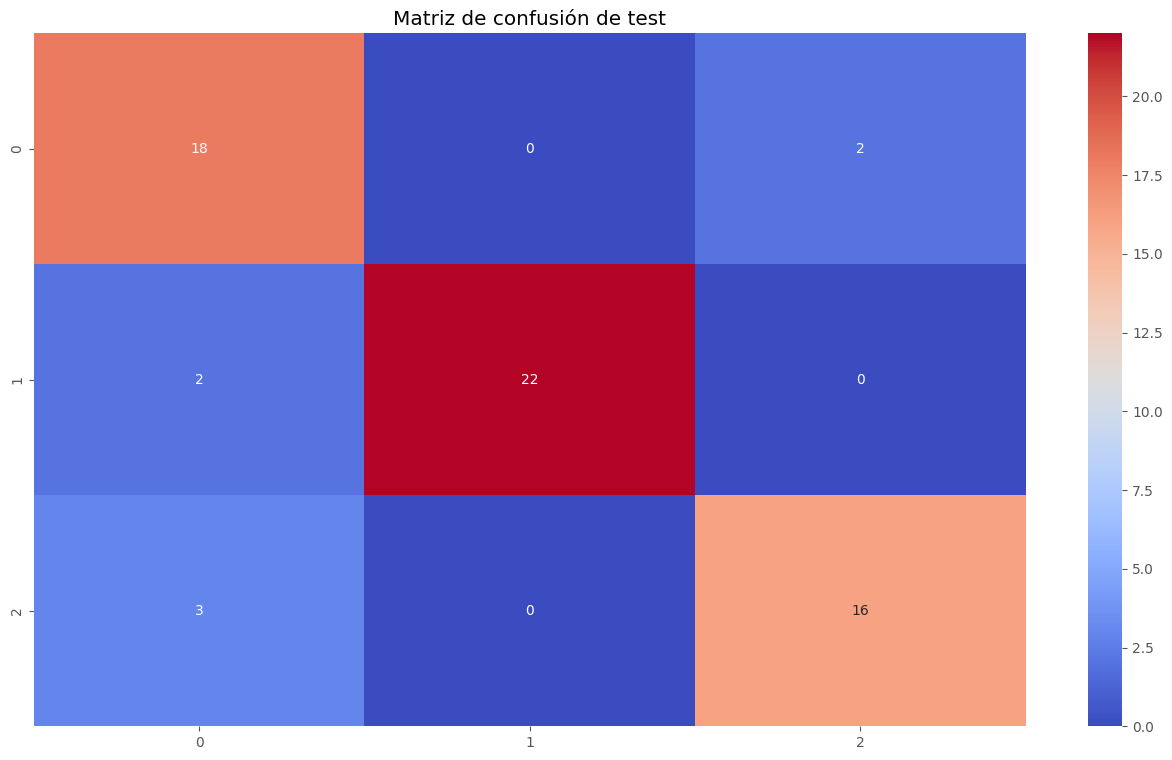

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, cmap = "coolwarm")
plt.title("Matriz de confusión de test")
plt.show()

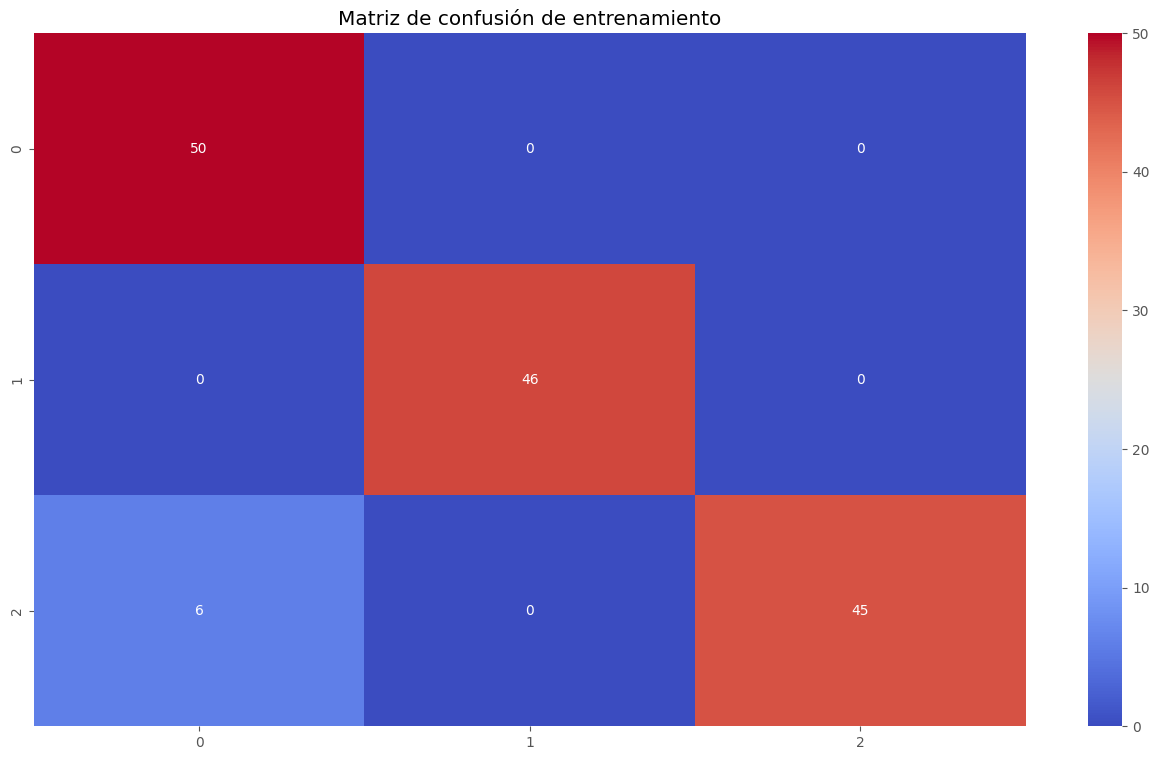

In [ ]:
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, cmap = "coolwarm")
plt.title("Matriz de confusión de entrenamiento")
plt.show()

En base a las matrices de confusión, vemos que en general el modelo se comporta adecuadamente, en la matriz de test vemos que solo hay 7 valores que predice erroneamente (las que están fuera de la diagonal principal) y en train vemos solo 6, por lo que indica que el modelo se está ajustando correctamente.

# Octavo punto

Observamos un buen puntaje en ambos casos, por lo que podemos tomar este modelo para hacer predicciones del tipo de semilla

In [ ]:
print(f"Valor de exactitud para entrenamiento: {accuracy_score(y_train, y_train_pred)}")
print(f"Valor de exactitud para validación: {accuracy_score(y_test, y_test_pred)}")

Valor de exactitud para entrenamiento: 0.9591836734693877
Valor de exactitud para validación: 0.8888888888888888


# Noveno punto

In [ ]:
print(f"Valor de precisión (macro) para entrenamiento: {precision_score(y_train, y_train_pred, average='macro')}")
print(f"Valor de precisión (macro) para validación: {precision_score(y_test, y_test_pred, average='macro')}")

Valor de precisión (macro) para entrenamiento: 0.9642857142857143
Valor de precisión (macro) para validación: 0.8904991948470209


In [ ]:
print(f"Valor de sensibilidad (macro) para entrenamiento: {recall_score(y_train, y_train_pred, average='macro')}")
print(f"Valor de sensibilidad (macro) para validación: {recall_score(y_test, y_test_pred, average='macro')}")

Valor de sensibilidad (macro) para entrenamiento: 0.9607843137254902
Valor de sensibilidad (macro) para validación: 0.8862573099415204


In [ ]:
print(f"Valor de sensibilidad (macro) para entrenamiento: {f1_score(y_train, y_train_pred, average='macro')}")
print(f"Valor de sensibilidad (macro) para validación: {f1_score(y_test, y_test_pred, average='macro')}")

Valor de sensibilidad (macro) para entrenamiento: 0.9602987421383649
Valor de sensibilidad (macro) para validación: 0.8861986354402936


* La precisión del modelo en los datos de entrenamiento es alta, lo que indica que el modelo es capaz de predecir correctamente las etiquetas positivas en la mayoría de los casos.
* La sensibilidad también es alta en el conjunto de entrenamiento, lo que indica que el modelo es bueno para identificar los casos positivos.
* El puntaje F1 es alto para el conjunto de entrenamiento, sugiriendo un buen equilibrio entre precisión y sensibilidad.

# Décimo punto

Usando el mismo dataset y los mismos datos de entrenamiento y validación, aplicaremos la técnica de Clasificación Bayesiana; usaremos GaussianNB pues nuestras variables son continuas.

In [ ]:
modelo_nb = GaussianNB()
modelo_nb.fit(X_train, y_train)

y_train_pred = modelo_nb.predict(X_train)
y_test_pred = modelo_nb.predict(X_test)

In [ ]:
print(f"Valor de exactitud para entrenamiento: {accuracy_score(y_train, y_train_pred)}")
print(f"Valor de exactitud para validación: {accuracy_score(y_test, y_test_pred)}")

Valor de exactitud para entrenamiento: 0.8979591836734694
Valor de exactitud para validación: 0.8571428571428571


In [ ]:
print("Precisión, Sensibilidad y F1 para entrenamiento:\n", classification_report(y_train, y_train_pred))

Precisión, Sensibilidad y F1 para entrenamiento:
               precision    recall  f1-score   support

           1       0.86      0.84      0.85        50
           2       0.96      0.93      0.95        46
           3       0.89      0.92      0.90        51

    accuracy                           0.90       147
   macro avg       0.90      0.90      0.90       147
weighted avg       0.90      0.90      0.90       147



In [ ]:
print("Precisión, Sensibilidad y F1 para validación:\n", classification_report(y_test, y_test_pred))

Precisión, Sensibilidad y F1 para validación:
               precision    recall  f1-score   support

           1       0.79      0.75      0.77        20
           2       0.92      0.92      0.92        24
           3       0.85      0.89      0.87        19

    accuracy                           0.86        63
   macro avg       0.85      0.85      0.85        63
weighted avg       0.86      0.86      0.86        63



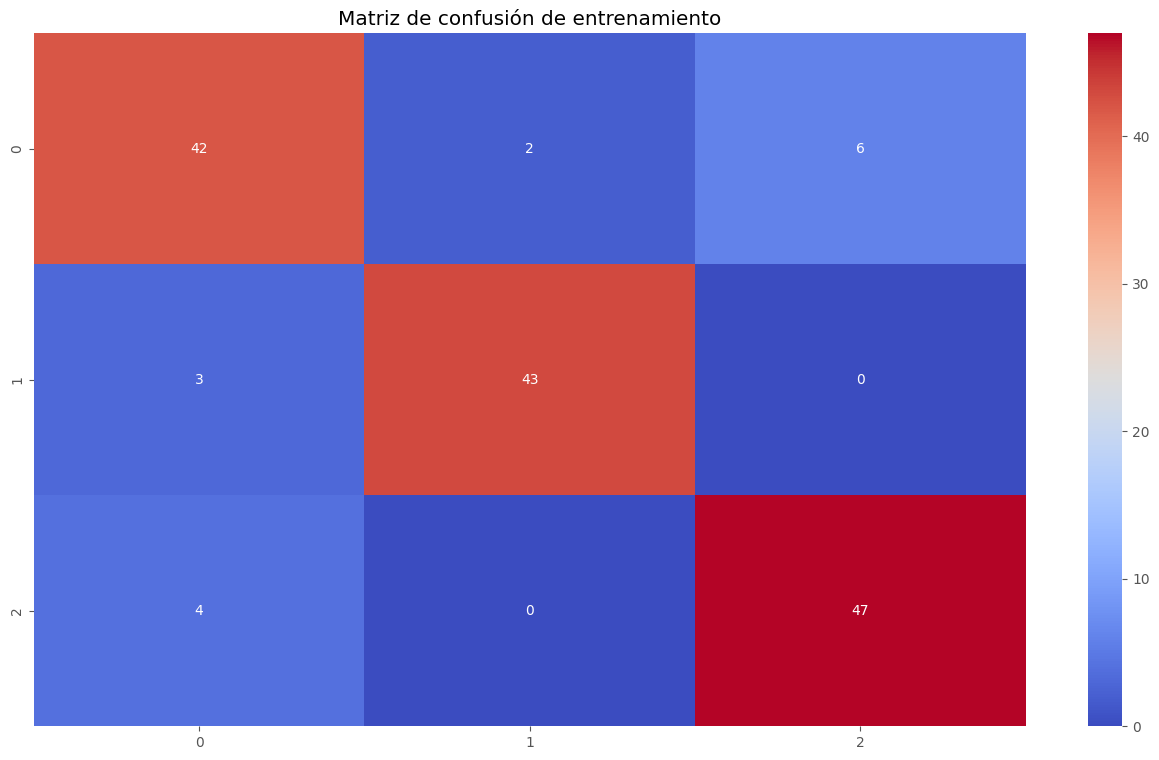

In [ ]:
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, cmap = "coolwarm")
plt.title("Matriz de confusión de entrenamiento")
plt.show()

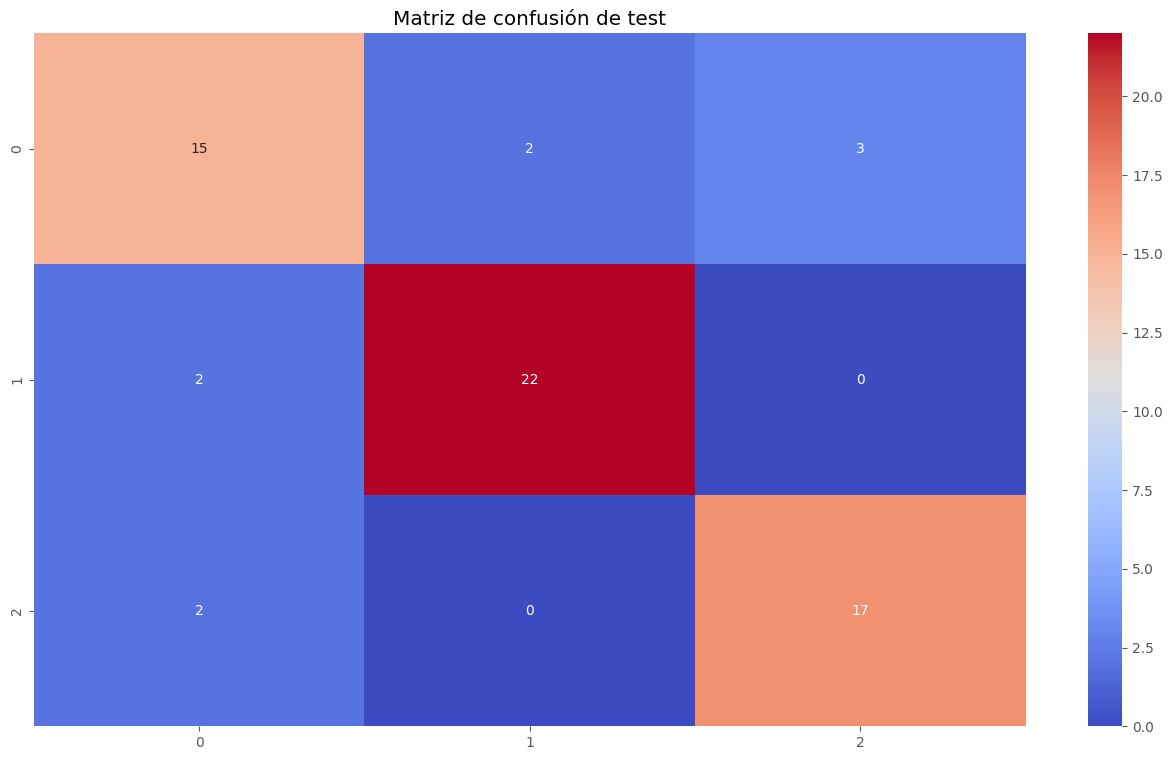

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, cmap = "coolwarm")
plt.title("Matriz de confusión de test")
plt.show()

Los resultados obtenidos para las métricas de exactitud, precisión, sensibilidad y F1 nos demuestran que este modelo tiene un peor rendimiento, comparado con el árbol de decisión.

Vamos a estandarizar nuestros datos y volver a entrenar el modelo para ver si mejora su desempeño, ya que GaussianNB asume que las variables siguen una distribución normal.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
modelo_nb_s = GaussianNB()
modelo_nb_s.fit(X_train_scaled, y_train)

y_train_pred = modelo_nb_s.predict(X_train_scaled)
y_test_pred = modelo_nb_s.predict(X_test_scaled)

In [ ]:
print(f"Valor de exactitud para entrenamiento: {accuracy_score(y_train, y_train_pred)}")
print(f"Valor de exactitud para validación: {accuracy_score(y_test, y_test_pred)}")

Valor de exactitud para entrenamiento: 0.8979591836734694
Valor de exactitud para validación: 0.8571428571428571


In [ ]:
print("Precisión, Sensibilidad y F1 para entrenamiento:\n", classification_report(y_train, y_train_pred))

Precisión, Sensibilidad y F1 para entrenamiento:
               precision    recall  f1-score   support

           1       0.86      0.84      0.85        50
           2       0.96      0.93      0.95        46
           3       0.89      0.92      0.90        51

    accuracy                           0.90       147
   macro avg       0.90      0.90      0.90       147
weighted avg       0.90      0.90      0.90       147



In [ ]:
print("Precisión, Sensibilidad y F1 para validación:\n", classification_report(y_test, y_test_pred))

Precisión, Sensibilidad y F1 para validación:
               precision    recall  f1-score   support

           1       0.79      0.75      0.77        20
           2       0.92      0.92      0.92        24
           3       0.85      0.89      0.87        19

    accuracy                           0.86        63
   macro avg       0.85      0.85      0.85        63
weighted avg       0.86      0.86      0.86        63



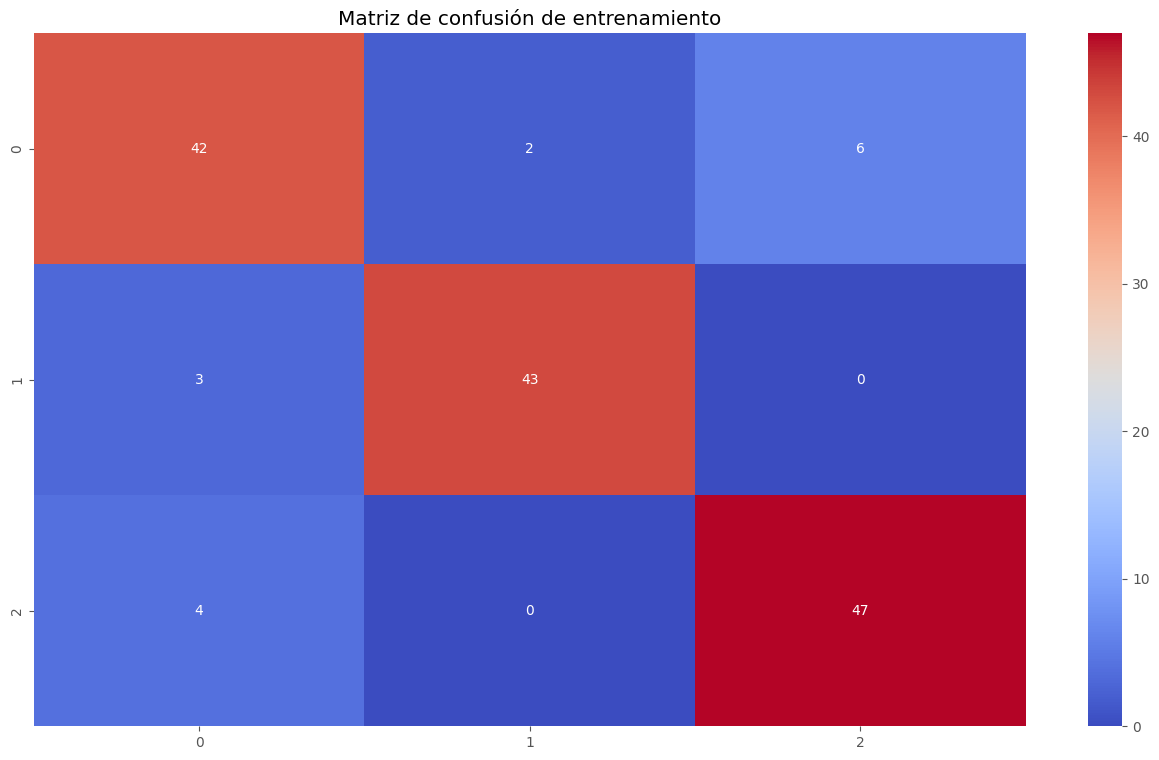

In [ ]:
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, cmap = "coolwarm")
plt.title("Matriz de confusión de entrenamiento")
plt.show()

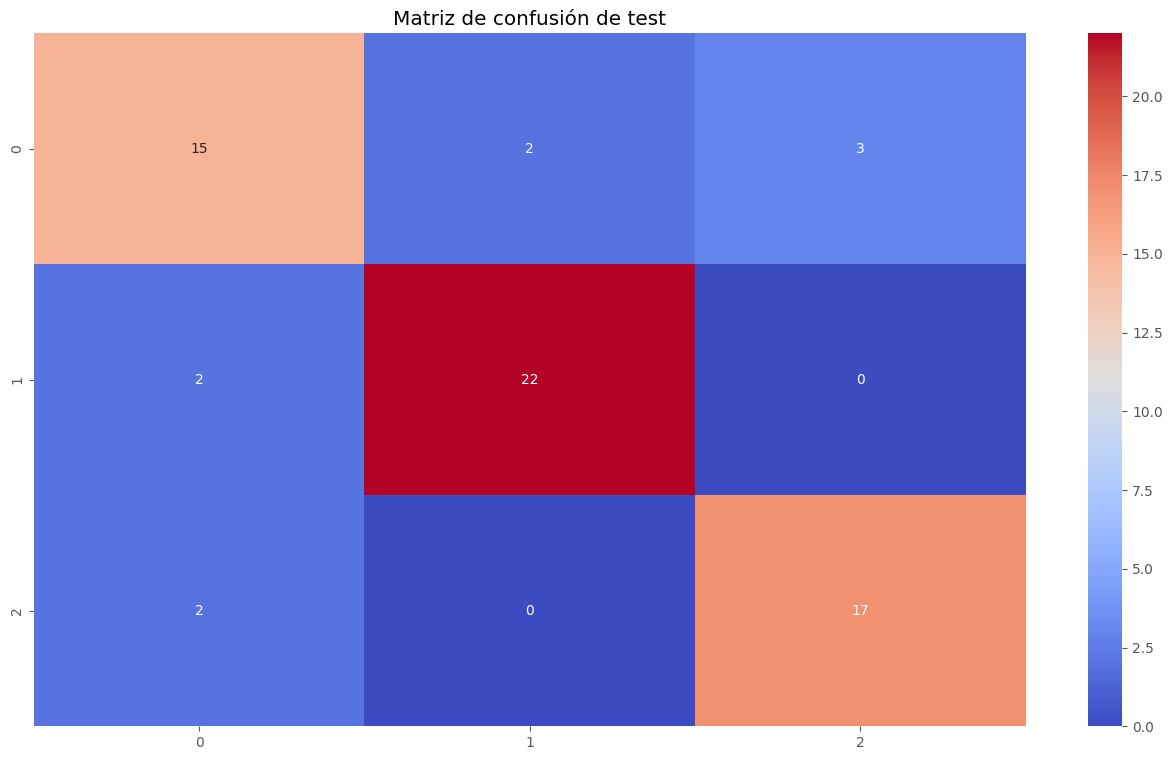

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, cmap = "coolwarm")
plt.title("Matriz de confusión de test")
plt.show()

Podemos observar que los resultados no mejoran, por lo que concluimos que el modelo de Árbol de Decisión, con estos datos, tiene un mejor desempeño.

# Análisis de resultados y conclusiones

* De las gráficas, el tipo de semilla Rosa es la que más sobresale tener un área mayor que las demás, igual que el perímetro y la compacidad (compactness). Viendo el aspecto del grano tanto su longitud como ancho es mayor a las demás. Es fácil de identificar.
* El modelo basado en la métrica de Gini es preferible para este caso debido a su mayor estabilidad y consistencia en la precisión a medida que aumenta la profundidad del árbol.
* En este caso, la mejor profundidad es de 3, un minimo de muestras de hojas de 1 y un minimo de muestras para la división de nodos de 2 para una exactitud de 0.9522.
* Para la matriz de correlación de Cramer's V, la variable que mayor correlación tiene con respecto a seedType es asymmetry coefficient con una correlación de 0.99 y la que menor correlación tiene es length of kernel groove con una correlación de 0.8; pero al aplicar SelectKbest, se observa que no se escoge asymmetry coefficient y sí se considera lengthOfKernelGroove.
* Del gráfico del árbol de decisión vemos que el nodo raíz usa WidthOfKernel; las variables que se usan en los nodos hijos son area y widhtOfKernel.
* De la matriz de confusión podemos ver que la mayoría de las predicciones están en la diagonal principal, lo que indica un alto número de clasificaciones correctas para todas las clases.
* La clase 2 (Canadiense) tiene algunos errores de clasificación hacia la clase 0 (Kama) (3 casos), y la clase 0 tiene algunos errores hacia la clase 2 (2 casos); esto podría indicar que las características de estas clases son algo similares para el modelo, lo que lleva a una confusión entre ellas. La clase 1 (Rosa) tiene pocos errores de clasificación (solo 2 casos mal clasificados como clase 0), lo que sugiere que esta clase está bien diferenciada por el modelo. Estos resultados son congruentes con las visualizaciones en las que se observaba que era fácil distinguir las semillas de tipo Rosa pero Kama y Canadiense tenían valores similares.
* Tanto el Gaussian Naive Bayes como el Árbol de Decisión demostraron ser efectivos para clasificar las semillas de trigo, con el Árbol de Decisión mostrando un rendimiento superior.



# Consulta datasets

* Dataset para aprendizaje supervisado: https://www.kaggle.com/datasets/mexwell/drug-consumption-classification
* Dataset para aprendizaje no supervisado: https://www.kaggle.com/datasets/abdallahwagih/company-employees
